# Aspect 1 - CNN MODEL

Suweyba 190281368

In [1]:
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn


import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:
# Define the Diagnosis class
class Diagnosis():
    def __init__(self, id, diagnosis, image_path):
        self.id = id
        self.diagnosis = diagnosis
        self.image_path = image_path

# Function to get .wav files
def get_wav_files():
    audio_path = '/content/drive/MyDrive/Respiratory_Sound_Database/audio_and_txt_files/'
    files = [f for f in listdir(audio_path) if isfile(join(audio_path, f))]  # Gets all files in dir
    wav_files = [f for f in files if f.endswith('.wav')]  # Gets wav files
    wav_files = sorted(wav_files)
    return wav_files, audio_path

# Function to fetch diagnosis data
def diagnosis_data():
    diagnosis = pd.read_csv('/content/drive/MyDrive/Respiratory_Sound_Database/patient_diagnosis.csv')

    wav_files, audio_path = get_wav_files()
    diag_dict = {101: "URTI"}
    diagnosis_list = []

    for index, row in diagnosis.iterrows():
        diag_dict[row[0]] = row[1]

    c = 0
    for f in wav_files:
        diagnosis_list.append(Diagnosis(c, diag_dict[int(f[:3])], audio_path+f))
        c+=1

    return diagnosis_list

In [3]:
#Extracts audio features from an audio file.
def audio_features(filename):
    sound, sample_rate = librosa.load(filename)
    stft = np.abs(librosa.stft(sound))# Compute Short-Time Fourier Transform (STFT) and its magnitude
    mfccs = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40), axis=1)# Compute Mel-frequency cepstral coefficients (MFCCs)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate), axis=1)
    mel = np.mean(librosa.feature.melspectrogram(y=sound, sr=sample_rate, n_mels=128).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate), axis=1)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(sound), sr=sample_rate), axis=1)

    concat = np.concatenate((mfccs, chroma, mel, contrast, tonnetz))
    return concat



In [4]:
# Function to fetch data points
def data_points():
    labels = []
    images = []

    classes = {"COPD":0, "Healthy":1, "URTI":2, "Bronchiectasis":3, "Pneumonia":4, "Bronchiolitis":5, "Asthma":6, "LRTI":7}

    for f in diagnosis_data():
        labels.append(classes[f.diagnosis])
        images.append(audio_features(f.image_path))

    return np.array(labels), np.array(images)

In [5]:
# Preprocessing function
def preprocessing(labels, images):

    # Remove Asthma and LRTI
    images = np.delete(images, np.where((labels == 7) | (labels == 6))[0], axis=0)
    labels = np.delete(labels, np.where((labels == 7) | (labels == 6))[0], axis=0)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=10)

    # Reshape data
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    return X_train, X_test, y_train, y_test



In [6]:
# Function to extract audio features
def extract_features(file_paths):
    features = []
    for file_path in file_paths:
        feature = audio_features(file_path)
        features.append(feature)
    return features

# Function to fetch data points
def data_points():
    labels = []
    images = []

    classes = {"COPD":0, "Healthy":1, "URTI":2, "Bronchiectasis":3, "Pneumonia":4, "Bronchiolitis":5, "Asthma":6, "LRTI":7}

    # Get file paths
    file_paths = [f.image_path for f in diagnosis_data()]

    # Extract features
    images = extract_features(file_paths)

    # Get labels
    for f in diagnosis_data():
        labels.append(classes[f.diagnosis])

    return np.array(labels), np.array(images)

start = timer()

labels, images = data_points()
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = preprocessing(labels, images)

print('Time taken: ', (timer() - start))

print('Shapes after preprocessing:')
print('X_train shape:', X_train_cnn.shape)
print('y_train shape:', y_train_cnn.shape)
print('X_test shape:', X_test_cnn.shape)
print('y_test shape:', y_test_cnn.shape)


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Time taken:  1795.468678483
Shapes after preprocessing:
X_train shape: (694, 193, 1)
y_train shape: (694,)
X_test shape: (174, 193, 1)
y_test shape: (174,)


In [7]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv1d(193, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        # Max pooling layer
        self.pool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        # Dropout layer
        self.dropout = nn.Dropout(0.5)
        # Fully connected layers
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 6)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))# Convolution -> BatchNorm -> ReLU
        x = self.pool(x) # Max pooling
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)# Flatten the feature maps
        x = self.dropout(x)# Dropout regularization
        x = x.view(-1, 256) # Reshape the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [8]:
# Initialize the model, loss function, and optimizer
model = CNN1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-10)

Epoch [1/100], Validation Loss: 1.578543, Validation Accuracy: 82.18%
Saving best model
Epoch [2/100], Validation Loss: 1.110728, Validation Accuracy: 82.18%
Saving best model
Epoch [3/100], Validation Loss: 0.714344, Validation Accuracy: 82.18%
Saving best model
Epoch [4/100], Validation Loss: 0.587324, Validation Accuracy: 82.18%
Saving best model
Epoch [5/100], Validation Loss: 0.546181, Validation Accuracy: 82.18%
Saving best model
Epoch [6/100], Validation Loss: 0.523664, Validation Accuracy: 82.18%
Saving best model
Epoch [7/100], Validation Loss: 0.519048, Validation Accuracy: 82.18%
Saving best model
Epoch [8/100], Validation Loss: 0.507388, Validation Accuracy: 82.18%
Saving best model
Epoch [9/100], Validation Loss: 0.486502, Validation Accuracy: 82.18%
Saving best model
Epoch [10/100], Validation Loss: 0.479986, Validation Accuracy: 82.18%
Saving best model
Epoch [11/100], Validation Loss: 0.469490, Validation Accuracy: 82.18%
Saving best model
Epoch [12/100], Validation Los

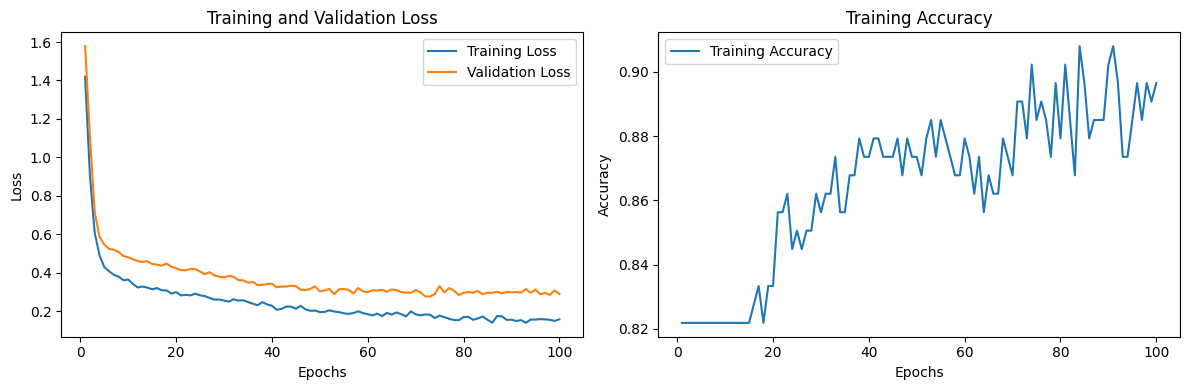

In [9]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the training function
def train(model, train_loader, valid_loader, criterion, optimizer, num_epochs, saved_model, evaluate_every_n_epochs=1):
    train_losses = []
    valid_losses = []
    valid_accuracies = []
    best_valid_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0

        for batch_inputs, batch_labels in train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        if (epoch + 1) % evaluate_every_n_epochs == 0:
            valid_loss, valid_acc = evaluate(model, valid_loader, criterion)
            valid_losses.append(valid_loss)
            valid_accuracies.append(valid_acc)

            print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {valid_loss:.6f}, Validation Accuracy: {100*valid_acc:.2f}%')

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                print('Saving best model')
                torch.save(model.state_dict(), saved_model)

    return train_losses, valid_losses, valid_accuracies


# Function to evaluate the model
def evaluate(model, data_loader, criterion):
    model.eval()
    num_batches = len(data_loader)
    epoch_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_inputs, batch_labels in data_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            outputs = model(batch_inputs).squeeze(dim=1)
            loss = criterion(outputs, batch_labels)

            # Accumulate loss
            epoch_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

    epoch_loss /= num_batches
    accuracy = correct / total

    return epoch_loss, accuracy

# Convert data into PyTorch DataLoader
train_dataset_cnn = [(torch.tensor(X_train_cnn[i], dtype=torch.float32), torch.tensor(y_train_cnn[i], dtype=torch.long)) for i in range(len(X_train_cnn))]
val_dataset_cnn = [(torch.tensor(X_test_cnn[i], dtype=torch.float32), torch.tensor(y_test_cnn[i], dtype=torch.long)) for i in range(len(X_test_cnn))]

train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=32, shuffle=True)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=32, shuffle=False)


# Train the model
num_epochs = 100
saved_model = 'best_cnn_model.pth'
train_losses, val_losses, val_accuracies = train(model, train_loader_cnn, val_loader_cnn, criterion, optimizer, num_epochs, saved_model)


import matplotlib.pyplot as plt

# Plotting the training loss and accuracy
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



In [10]:
# Test the model
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Load the best model
best_model = CNN1().to(device)
best_model.load_state_dict(torch.load(saved_model))

# Convert test data into DataLoader
test_dataset_cnn = [(torch.tensor(X_test_cnn[i], dtype=torch.float32), torch.tensor(y_test_cnn[i], dtype=torch.long)) for i in range(len(X_test_cnn))]
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=32, shuffle=False)

# Test the model
test_accuracy = test(best_model, test_loader_cnn)
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Evaluate using F1 score, precision, and accuracy
def evaluate_metrics(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    report = classification_report(y_true, y_pred, target_names=["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumonia", "Bronchiolitis"])

    return report

# Evaluate metrics
report = evaluate_metrics(best_model, test_loader_cnn)
print("Classification Report:")
print(report)




Test Accuracy: 87.93%
Classification Report:
                precision    recall  f1-score   support

          COPD       0.94      0.98      0.96       143
       Healthy       0.50      0.80      0.62        10
          URTI       0.00      0.00      0.00         7
Bronchiectasis       1.00      0.67      0.80         3
     Pneumonia       0.50      0.30      0.37        10
 Bronchiolitis       0.00      0.00      0.00         1

      accuracy                           0.88       174
     macro avg       0.49      0.46      0.46       174
  weighted avg       0.85      0.88      0.86       174



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Aspect 2 - RNN MODEL


In [11]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [12]:
import pandas as pd

# Load diagnosis data into a DataFrame
diagnosis_df = pd.read_csv('/content/drive/MyDrive/Respiratory_Sound_Database/patient_diagnosis.csv', header=None, names=['Patient_ID', 'Diagnosis'], index_col=False)

print(diagnosis_df.head())


   Patient_ID Diagnosis
0         101      URTI
1         102   Healthy
2         103    Asthma
3         104      COPD
4         105      URTI


In [13]:
# Function to extract features from audio files for both wheezes and crackles
def rnn_feature_extraction(dir_):
    X_ = []
    y_ = []
    for soundFile in os.listdir(dir_):
        if soundFile.endswith('.wav'):
            patient_id = int(soundFile.split('_')[0])
            disease = diagnosis_df.loc[diagnosis_df['Patient_ID'] == patient_id, 'Diagnosis'].values[0]
            print("Patient ID:", patient_id, "Disease:", disease)
            # Read annotation file
            annotation_file = soundFile.replace('.wav', '.txt')
            with open(os.path.join(dir_, annotation_file), 'r') as f:
                lines = f.readlines()
                crackles = [int(line.split()[2]) for line in lines]
                wheezes = [int(line.split()[3]) for line in lines]
                print("crackles:", crackles)
                print("wheezes:", wheezes)
            if any(wheezes) or any(crackles):
                audio_path = os.path.join(dir_, soundFile)
                features = audio_features(audio_path)  # Extract audio features
                X_.append(features)
                if any(crackles):
                    y_.append('crackles')
                elif any(wheezes):
                    y_.append('wheezes')
            else:
                print("No wheezes or crackles detected. Skipping file:", soundFile)
    return X_, y_

# Extract audio features
def audio_features(filename):
    sound, sample_rate = librosa.load(filename)
    stft = np.abs(librosa.stft(sound))
    mfccs = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40), axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate), axis=1)
    mel = np.mean(librosa.feature.melspectrogram(y=sound, sr=sample_rate, n_mels=128).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate), axis=1)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(sound), sr=sample_rate), axis=1)

    concat = np.concatenate((mfccs, chroma, mel, contrast, tonnetz))
    return concat

# Extract features for both wheezes and crackles
audio_data = '/content/drive/MyDrive/Respiratory_Sound_Database/audio_and_txt_files'
X, y = rnn_feature_extraction(audio_data)




Patient ID: 158 Disease: COPD
crackles: [0, 1, 1, 0, 1, 1, 0, 1, 1]
wheezes: [1, 1, 0, 0, 0, 0, 0, 1, 1]
Patient ID: 158 Disease: COPD
crackles: [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
wheezes: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Patient ID: 160 Disease: COPD
crackles: [0, 0]
wheezes: [0, 1]
Patient ID: 160 Disease: COPD
crackles: [0, 0]
wheezes: [1, 1]
Patient ID: 160 Disease: COPD
crackles: [0, 0]
wheezes: [1, 1]
Patient ID: 160 Disease: COPD
crackles: [1, 0]
wheezes: [1, 1]
Patient ID: 159 Disease: Healthy
crackles: [0, 0, 0, 0, 0, 0, 0, 0, 0]
wheezes: [0, 0, 0, 0, 0, 0, 0, 0, 0]
No wheezes or crackles detected. Skipping file: 159_1b1_Pr_sc_Meditron.wav
Patient ID: 160 Disease: COPD
crackles: [1, 1]
wheezes: [1, 1]
Patient ID: 160 Disease: COPD
crackles: [0, 0, 0, 0, 0]
wheezes: [0, 1, 1, 1, 0]
Patient ID: 160 Disease: COPD
crackles: [0, 0, 0, 0, 0]
wheezes: [1, 1, 1, 1, 0]
Patient ID: 160 Disease: COPD
crackles: [1, 1, 1, 1, 1]
wheezes: [1, 1, 1, 1, 0]
Patient ID: 160 Disease: COPD
c

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Patient ID: 160 Disease: COPD
crackles: [1, 1, 1, 1]
wheezes: [1, 1, 1, 1]
Patient ID: 160 Disease: COPD
crackles: [0, 0, 0, 0, 0]
wheezes: [1, 1, 1, 1, 0]
Patient ID: 160 Disease: COPD
crackles: [0, 1, 0, 0, 0]
wheezes: [1, 1, 1, 1, 0]
Patient ID: 160 Disease: COPD
crackles: [0, 0, 0, 0]
wheezes: [1, 1, 1, 1]
Patient ID: 160 Disease: COPD
crackles: [1, 1, 1, 1, 1, 1, 1]
wheezes: [0, 0, 0, 0, 0, 0, 0]
Patient ID: 160 Disease: COPD
crackles: [0, 0, 0, 0]
wheezes: [1, 1, 1, 1]
Patient ID: 160 Disease: COPD
crackles: [1, 1, 1, 1, 1, 1, 1]
wheezes: [0, 0, 0, 0, 0, 0, 0]
Patient ID: 160 Disease: COPD
crackles: [1, 1, 1, 1]
wheezes: [1, 1, 0, 0]
Patient ID: 160 Disease: COPD
crackles: [0, 1, 0, 0]
wheezes: [1, 1, 1, 1]
Patient ID: 160 Disease: COPD
crackles: [0, 0, 0, 1, 0, 0, 0]
wheezes: [0, 0, 0, 0, 0, 0, 0]
Patient ID: 160 Disease: COPD
crackles: [0, 0, 0, 0, 0, 0, 0]
wheezes: [0, 0, 0, 0, 0, 0, 0]
No wheezes or crackles detected. Skipping file: 160_2b4_Tc_mc_AKGC417L.wav
Patient ID: 162 

In [14]:
from sklearn.preprocessing import LabelEncoder

# Convert labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert labels to PyTorch tensor
y_tensor = torch.tensor(y_encoded, dtype=torch.float32)


# Convert feature list to NumPy array
X = np.asarray(X)




# Split the data into training and validation sets
X_train_rnn, X_val_rnn, y_train_rnn, y_val_rnn = train_test_split(X, y_tensor, test_size=0.2, random_state=42)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor_rnn = torch.tensor(X_train_rnn, dtype=torch.float32)
X_val_tensor_rnn = torch.tensor(X_val_rnn, dtype=torch.float32)

print("Shape of X_train_tensor:", X_train_tensor_rnn.shape)
print("Shape of X_val_tensor:", X_val_tensor_rnn.shape)
print("Shape of y_train:", y_train_rnn.shape)
print("Shape of y_val:", y_val_rnn.shape)




Shape of X_train_tensor: torch.Size([475, 193])
Shape of X_val_tensor: torch.Size([119, 193])
Shape of y_train: torch.Size([475])
Shape of y_val: torch.Size([119])


In [15]:
# Create TensorDataset objects
train_dataset_rnn = TensorDataset(X_train_tensor_rnn, y_train_rnn)
val_dataset_rnn = TensorDataset(X_val_tensor_rnn, y_val_rnn)

# Create DataLoader objects
batch_size = 32
train_loader_rnn = DataLoader(train_dataset_rnn, batch_size=batch_size, shuffle=True)
val_loader_rnn = DataLoader(val_dataset_rnn, batch_size=batch_size)

In [43]:
# Define RNN model
class RNN1(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_prob=0.45):
        super(RNN1, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(1, batch_size, hidden_size).to(x.device)
        output, _ = self.rnn(x, h0)
        output = self.dropout(output)
        output = self.fc(output[:, -1, :])
        return output.squeeze(1)




# Initialize the model
input_size = X_train_tensor_rnn.shape[1]
hidden_size = 128
model = RNN1(input_size, hidden_size)



# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-9)


Epoch 1/100, Loss: 0.7475, Val Loss: 0.6866, Val Acc: 0.5966
Epoch 2/100, Loss: 0.6798, Val Loss: 0.6406, Val Acc: 0.6975
Epoch 3/100, Loss: 0.6199, Val Loss: 0.6066, Val Acc: 0.7227
Epoch 4/100, Loss: 0.5871, Val Loss: 0.5900, Val Acc: 0.7647
Epoch 5/100, Loss: 0.5839, Val Loss: 0.5788, Val Acc: 0.7647
Epoch 6/100, Loss: 0.5854, Val Loss: 0.5730, Val Acc: 0.7647
Epoch 7/100, Loss: 0.5381, Val Loss: 0.5679, Val Acc: 0.7647
Epoch 8/100, Loss: 0.5312, Val Loss: 0.5666, Val Acc: 0.7647
Epoch 9/100, Loss: 0.5442, Val Loss: 0.5623, Val Acc: 0.7647
Epoch 10/100, Loss: 0.5448, Val Loss: 0.5601, Val Acc: 0.7647
Epoch 11/100, Loss: 0.5249, Val Loss: 0.5582, Val Acc: 0.7647
Epoch 12/100, Loss: 0.5256, Val Loss: 0.5548, Val Acc: 0.7647
Epoch 13/100, Loss: 0.5170, Val Loss: 0.5546, Val Acc: 0.7647
Epoch 14/100, Loss: 0.5294, Val Loss: 0.5528, Val Acc: 0.7647
Epoch 15/100, Loss: 0.5334, Val Loss: 0.5538, Val Acc: 0.7647
Epoch 16/100, Loss: 0.5237, Val Loss: 0.5544, Val Acc: 0.7647
Epoch 17/100, Los

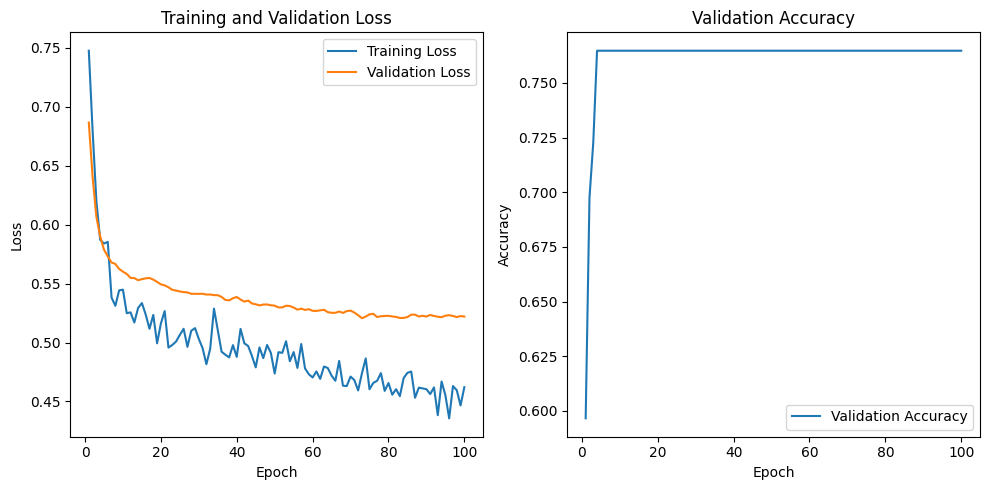

In [41]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 100
import matplotlib.pyplot as plt

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader_rnn:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader_rnn.dataset)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct_preds = 0

    with torch.no_grad():
        for inputs, labels in val_loader_rnn:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.unsqueeze(1))
            val_loss += criterion(outputs, labels).item() * inputs.size(0)
            predicted = torch.round(torch.sigmoid(outputs))
            correct_preds += (predicted == labels).sum().item()

    val_loss /= len(val_loader_rnn.dataset)
    val_losses.append(val_loss)

    val_accuracy = correct_preds / len(val_loader_rnn.dataset)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

# Plotting the graphs
plt.figure(figsize=(10, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'trained_rnn_model.pth')


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Lists to store predictions and true labels
val_predictions = []
true_labels = []

# Set model to evaluation mode
model.eval()

with torch.no_grad():
    for inputs, labels in val_loader_rnn:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs.unsqueeze(1))
        predicted = torch.round(torch.sigmoid(outputs)).cpu().numpy()  # Convert predictions to numpy array
        val_predictions.extend(predicted)
        true_labels.extend(labels.cpu().numpy())  # Convert true labels to numpy array

# Convert lists to numpy arrays
val_predictions = np.array(val_predictions)
true_labels = np.array(true_labels)

# Calculate test accuracy
test_accuracy = accuracy_score(true_labels, val_predictions)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Test Accuracy: 75.63%


In [19]:
from sklearn.metrics import classification_report

# Generate classification report
class_report = classification_report(true_labels, val_predictions, labels=[0, 1], target_names=['Crackles', 'Wheezes'])

# Print the classification report
print(class_report)



              precision    recall  f1-score   support

    Crackles       0.77      0.98      0.86        91
     Wheezes       0.33      0.04      0.06        28

    accuracy                           0.76       119
   macro avg       0.55      0.51      0.46       119
weighted avg       0.67      0.76      0.67       119



# Combined


In [20]:
# Extract features for both wheezes and crackles
audio_data = '/content/drive/MyDrive/Respiratory_Sound_Database/audio_and_txt_files'
X, y = rnn_feature_extraction(audio_data)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Convert features and labels to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y_encoded, dtype=torch.long)

# Split the data into training and validation sets
X_train_comb, X_val_comb, y_train_comb, y_val_comb = train_test_split(X, y, test_size=0.2, random_state=42)

Patient ID: 158 Disease: COPD
crackles: [0, 1, 1, 0, 1, 1, 0, 1, 1]
wheezes: [1, 1, 0, 0, 0, 0, 0, 1, 1]
Patient ID: 158 Disease: COPD
crackles: [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
wheezes: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Patient ID: 160 Disease: COPD
crackles: [0, 0]
wheezes: [0, 1]
Patient ID: 160 Disease: COPD
crackles: [0, 0]
wheezes: [1, 1]
Patient ID: 160 Disease: COPD
crackles: [0, 0]
wheezes: [1, 1]
Patient ID: 160 Disease: COPD
crackles: [1, 0]
wheezes: [1, 1]
Patient ID: 159 Disease: Healthy
crackles: [0, 0, 0, 0, 0, 0, 0, 0, 0]
wheezes: [0, 0, 0, 0, 0, 0, 0, 0, 0]
No wheezes or crackles detected. Skipping file: 159_1b1_Pr_sc_Meditron.wav
Patient ID: 160 Disease: COPD
crackles: [1, 1]
wheezes: [1, 1]
Patient ID: 160 Disease: COPD
crackles: [0, 0, 0, 0, 0]
wheezes: [0, 1, 1, 1, 0]
Patient ID: 160 Disease: COPD
crackles: [0, 0, 0, 0, 0]
wheezes: [1, 1, 1, 1, 0]
Patient ID: 160 Disease: COPD
crackles: [1, 1, 1, 1, 1]
wheezes: [1, 1, 1, 1, 0]
Patient ID: 160 Disease: COPD
c

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Patient ID: 160 Disease: COPD
crackles: [1, 1, 1, 1]
wheezes: [1, 1, 1, 1]
Patient ID: 160 Disease: COPD
crackles: [0, 0, 0, 0, 0]
wheezes: [1, 1, 1, 1, 0]
Patient ID: 160 Disease: COPD
crackles: [0, 1, 0, 0, 0]
wheezes: [1, 1, 1, 1, 0]
Patient ID: 160 Disease: COPD
crackles: [0, 0, 0, 0]
wheezes: [1, 1, 1, 1]
Patient ID: 160 Disease: COPD
crackles: [1, 1, 1, 1, 1, 1, 1]
wheezes: [0, 0, 0, 0, 0, 0, 0]
Patient ID: 160 Disease: COPD
crackles: [0, 0, 0, 0]
wheezes: [1, 1, 1, 1]
Patient ID: 160 Disease: COPD
crackles: [1, 1, 1, 1, 1, 1, 1]
wheezes: [0, 0, 0, 0, 0, 0, 0]
Patient ID: 160 Disease: COPD
crackles: [1, 1, 1, 1]
wheezes: [1, 1, 0, 0]
Patient ID: 160 Disease: COPD
crackles: [0, 1, 0, 0]
wheezes: [1, 1, 1, 1]
Patient ID: 160 Disease: COPD
crackles: [0, 0, 0, 1, 0, 0, 0]
wheezes: [0, 0, 0, 0, 0, 0, 0]
Patient ID: 160 Disease: COPD
crackles: [0, 0, 0, 0, 0, 0, 0]
wheezes: [0, 0, 0, 0, 0, 0, 0]
No wheezes or crackles detected. Skipping file: 160_2b4_Tc_mc_AKGC417L.wav
Patient ID: 162 

<ipython-input-20-308521631c12>:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  X = torch.tensor(X, dtype=torch.float32)


In [21]:


#Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(193, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.dropout = nn.Dropout(0.45)
        self.fc = nn.Linear(256, 6)
    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Define RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_prob=0.45):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, 6)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        output, _ = self.rnn(x, h0)
        output = self.dropout(output)
        return output

# Define Combined Model
class CombinedModel(nn.Module):
    def __init__(self, cnn_model, rnn_model):
        super(CombinedModel, self).__init__()
        self.cnn_model = cnn_model
        self.rnn_model = rnn_model
        self.fc1 = nn.Linear(cnn_model.fc.out_features + rnn_model.fc.out_features, 128)
        self.fc2 = nn.Linear(128, cnn_model.fc.out_features)

    def forward(self, x_cnn, x_rnn):
        cnn_features = self.cnn_model(x_cnn)
        rnn_features = self.rnn_model(x_rnn)
        combined_features = torch.cat((cnn_features, rnn_features), dim=1)
        x = torch.relu(self.fc1(combined_features))
        x = self.fc2(x)
        return x



In [22]:
# Define CNN and RNN models
cnn_model = CNN()
rnn_model = RNN(input_size=6, hidden_size=128)  # input_size to match the output size of the CNN model

# Define Combined Model
combined_model = CombinedModel(cnn_model, rnn_model)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_model.parameters(), lr=1e-4, weight_decay=1e-8)

In [23]:
train_dataset_comb = TensorDataset(X_train_comb.unsqueeze(1), y_train_comb)
train_loader_comb = DataLoader(train_dataset_comb, batch_size=batch_size, shuffle=True)

# Create a DataLoader for the validation set
val_dataset_comb = TensorDataset(X_val_comb.unsqueeze(1), y_val_comb)
val_loader_comb = DataLoader(val_dataset_comb, batch_size=batch_size)

Epoch 1/100, Loss: 4.8223, Validation Loss: 4.8443, Validation Accuracy: 0.0000
Epoch 2/100, Loss: 4.7750, Validation Loss: 4.8086, Validation Accuracy: 0.0000
Epoch 3/100, Loss: 4.7177, Validation Loss: 4.7386, Validation Accuracy: 0.0840
Epoch 4/100, Loss: 4.6408, Validation Loss: 4.6548, Validation Accuracy: 0.4034
Epoch 5/100, Loss: 4.5954, Validation Loss: 4.5779, Validation Accuracy: 0.6975
Epoch 6/100, Loss: 4.5508, Validation Loss: 4.5069, Validation Accuracy: 0.7563
Epoch 7/100, Loss: 4.4308, Validation Loss: 4.4222, Validation Accuracy: 0.7647
Epoch 8/100, Loss: 4.3805, Validation Loss: 4.3460, Validation Accuracy: 0.7647
Epoch 9/100, Loss: 4.3447, Validation Loss: 4.2648, Validation Accuracy: 0.7647
Epoch 10/100, Loss: 4.2330, Validation Loss: 4.2061, Validation Accuracy: 0.7647
Epoch 11/100, Loss: 4.1815, Validation Loss: 4.1233, Validation Accuracy: 0.7647
Epoch 12/100, Loss: 4.0607, Validation Loss: 4.0345, Validation Accuracy: 0.7647
Epoch 13/100, Loss: 4.0350, Validatio

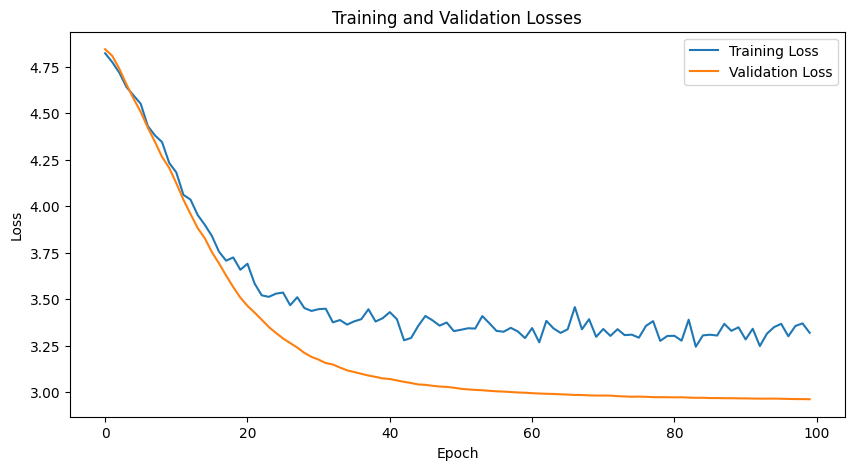

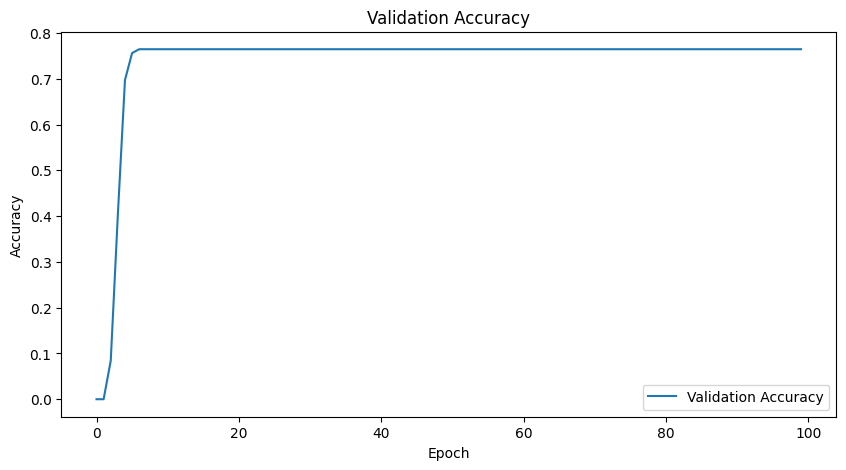

In [24]:

# Train the combined model
num_epochs = 100
batch_size = 32

import matplotlib.pyplot as plt

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
val_accuracies = []

# Train the combined model
for epoch in range(num_epochs):
    combined_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader_comb:
        optimizer.zero_grad()
        cnn_outputs = cnn_model(inputs.permute(0, 2, 1))
        cnn_outputs = cnn_outputs.unsqueeze(1)
        rnn_outputs = rnn_model(cnn_outputs)
        rnn_outputs = rnn_outputs.view(-1, rnn_outputs.size(2))
        labels = labels.view(-1)
        loss = criterion(rnn_outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader_comb.dataset)
    train_losses.append(epoch_loss)

    # Validation
    combined_model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader_comb:
            cnn_outputs = cnn_model(inputs.permute(0, 2, 1))
            cnn_outputs = cnn_outputs.unsqueeze(1)
            rnn_outputs = rnn_model(cnn_outputs)
            rnn_outputs = rnn_outputs.view(-1, rnn_outputs.size(2))
            labels = labels.view(-1)
            val_loss = criterion(rnn_outputs, labels)
            val_running_loss += val_loss.item() * inputs.size(0)

            _, predicted = torch.max(rnn_outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_loader_comb.dataset)
    val_accuracy = correct / total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plotting the graphs
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# Save the trained model
torch.save(combined_model.state_dict(), 'trained_combined_model.pth')


In [25]:
from sklearn.metrics import precision_recall_fscore_support

# Put the model in evaluation mode
combined_model.eval()

# Create a DataLoader for the validation set
val_dataset_comb = TensorDataset(X_val_comb.unsqueeze(1), y_val_comb)
val_loader_comb = DataLoader(val_dataset_comb, batch_size=batch_size)

# Lists to store predictions and ground truth labels
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader_comb:
        # Forward pass through the combined model
        cnn_outputs = cnn_model(inputs.permute(0, 2, 1))
        cnn_outputs = cnn_outputs.unsqueeze(1)
        rnn_outputs = rnn_model(cnn_outputs)
        rnn_outputs = rnn_outputs.view(-1, rnn_outputs.size(2))  # Flatten the output

        # Get predictions
        predictions = torch.argmax(rnn_outputs, dim=1)

        # Store predictions and ground truth labels
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate evaluation metrics for each class
precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_predictions)

# Print evaluation metrics for each class
for i in range(num_classes):
    print(f"Class {i} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1 Score: {f1[i]:.4f}, Support: {support[i]}")


Class 0 - Precision: 0.7647, Recall: 1.0000, F1 Score: 0.8667, Support: 91
Class 1 - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Support: 28


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# case study

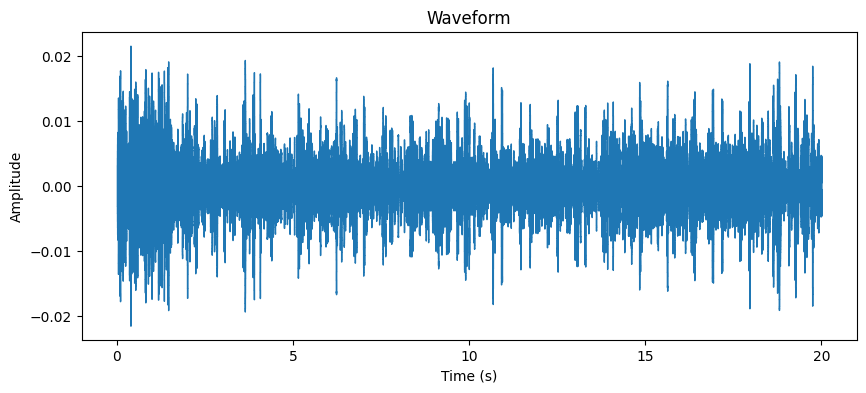

<ipython-input-140-82f3dc788309>:21: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(audio_data), ref=np.max)


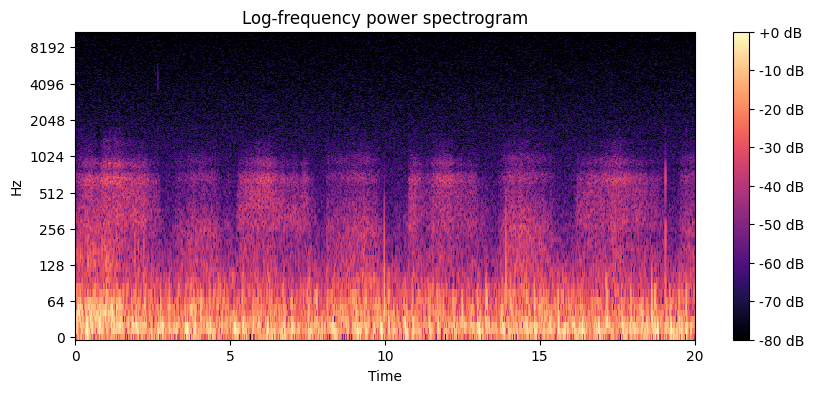

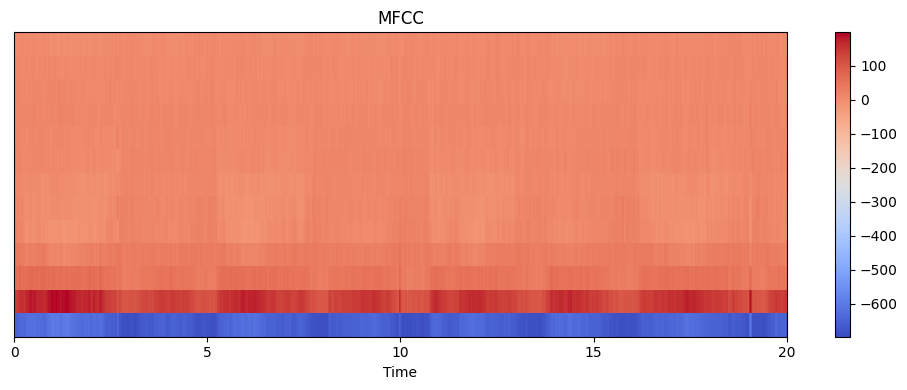

In [140]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Path to the audio file
audio_file_path = "/content/drive/MyDrive/Respiratory_Sound_Database/audio_and_txt_files/128_1b3_Tc_mc_LittC2SE.wav"

# Load the audio file
audio_data, sr = librosa.load(audio_file_path)

# Display the waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio_data, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Plot the spectrogram
plt.figure(figsize=(10, 4))
D = librosa.amplitude_to_db(librosa.stft(audio_data), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.show()

# Extract features (e.g., MFCCs)
mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()


In [27]:
import numpy as np
import librosa

# Function to extract audio features
def extract_audio_features(filename):
    # Load the audio file
    sound, sample_rate = librosa.load(filename)

    # Extract features
    stft = np.abs(librosa.stft(sound))
    mfccs = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40), axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate), axis=1)
    mel = np.mean(librosa.feature.melspectrogram(y=sound, sr=sample_rate, n_mels=128).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate), axis=1)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(sound), sr=sample_rate), axis=1)

    concat_features = np.concatenate((mfccs, chroma, mel, contrast, tonnetz))

    return concat_features

# Extract audio features
audio_features = extract_audio_features(audio_file_path)



In [137]:
# Load the audio file
audio_file = "/content/drive/MyDrive/Respiratory_Sound_Database/audio_and_txt_files/128_1b3_Tc_mc_LittC2SE.wav"
features = extract_audio_features(audio_file)

# Preprocess the features
input_data_cnn = torch.tensor(features, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)


# Make prediction
best_model.eval()
with torch.no_grad():
    output_cnn = best_model(input_data_cnn)
    _, predicted_cnn = torch.max(output_cnn, 1)

# Decode the predicted label
classes = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumonia", "Bronchiolitis"]
predicted_label_cnn = classes[predicted_cnn.item()]

# Calculate softmax probabilities
softmax_probs = torch.softmax(output_cnn, dim=1)

# Extract probability associated with the predicted class
predicted_prob = softmax_probs[0, predicted_cnn.item()].item()

print(f"Predicted Class: {predicted_label_cnn}")
print(f"Confidence: {predicted_prob * 100:.2f}%")


Predicted Class: COPD
Confidence: 99.94%


In [138]:
import torch

# Load the RNN model
rnn_model = RNN1(input_size=193, hidden_size=128)
rnn_model.load_state_dict(torch.load('trained_rnn_model.pth'))

# Convert audio features to PyTorch tensor
input_data_rnn = torch.tensor(features, dtype=torch.float32)

# Reshape the input tensor to match the expected dimensions
input_data_rnn = input_data_rnn.view(1, -1, 193)  #  reshape to [batch_size, seq_length, input_size]

# Make prediction
with torch.no_grad():
    rnn_model.eval()
    output_rnn = rnn_model(input_data_rnn)
    predicted_score = torch.sigmoid(output_rnn).item()
    predicted_label = 'Crackles' if predicted_score >= 0.5 else 'Wheezes'
    confidence = predicted_score if predicted_label == 'Crackles' else 1 - predicted_score

print(f"Predicted Class: {predicted_label}")
print(f"Confidence: {confidence:.2f}")







Predicted Class: Wheezes
Confidence: 0.78
